----

> # <span style="color:blue"> Basic Coding Test Level Data Processing </span>

---

- In this notebook, I am going to show some basic processing of data I download from fda.gov,

- The analysis done is here rather simple, usually asked in coding interviews by several companies recrutiting for Data Scientist positions
- The analysis I do here is still more advanced than typically asked in the interviews
- This is the first notebook in the series of notebooks I am going to publish here in the processing of building my public Data Science portfolio
----

> # <span style="color:blue"> Description </span>

## The following things are done in this notebooks,
1. Scraped data from fda.gov using **Selenium** to obtain the list of approved data in the last 120 years
2. Preprocess this data, store into proper folders, check the data integrity and make it ready for further analysis using **Pandas**, **Numpy** and **Scikit-learn**
3. Perform analysis based on the information available, especially using the company names and ingredients used in the drugs
4. Display advanced graphics in **Plotly**, **seaborn** to display various information
5. The analysis is done at a very basic level, more like what is answered in interviews! 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from collections import defaultdict
from collections import Counter
from itertools import chain
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
import plotly.express as plx
from plotly.subplots import make_subplots
from ipywidgets import widgets
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
import plotly.io as pio
#pio.renderers.default = "browser"
path = "C:\\Users\\Vikram\\Documents\\ML\\git_local\\Vikramardham\\fda_drugs\\data\\"
YEARS = np.arange(1900, 2021)
MONTHS = [
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
    'September', 'October', 'November', 'December'
]

----
## Let us have a look at one of the test files
----

In [2]:
file = Path(path)/'2020'/'January'/'fda.csv'
data_test = pd.read_csv(file)

In [3]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Approval Date                419 non-null    object
 1   Drug Name                    419 non-null    object
 2   Submission                   419 non-null    object
 3   Active Ingredients           419 non-null    object
 4   Company                      419 non-null    object
 5   Submission Classification *  341 non-null    object
 6   Submission Status            419 non-null    object
dtypes: object(7)
memory usage: 23.0+ KB


In [4]:
data_test.describe()

,Approval Date,Drug Name,Submission,Active Ingredients,Company,Submission Classification *,Submission Status
count,419,419,419,419,419,341,419
unique,22,286,61,178,161,10,2
top,01/21/2020,DIVALPROEX SODIUMANDA #078597,ORIG-1,DIVALPROEX SODIUM,ZYDUS PHARMS USA INC,Labeling,Approval
freq,43,9,73,60,19,309,404


> ### We have a few interesting columns, Approval Date Drug Name, Active Ingredients and Company
+ So, we can try to understand how Approval rates have evolved over times
+ What are the major players in the business
+ What ingredients are the most common
+ How have these ingredients evolved over time
+ How different companies evolved over time
+ How are the major players related to each other?
+ How are different ingredients correlated with each other?

Below, we try to answer these questions

> ### Before we do anything, we check the dowloaded data integrity
1. Do we have proper files in the proper folders?
2. Are there any files with invalid data?

In [5]:
'''Build dictionary with data from 1900-2020 for months
Jan-Dec'''
drug_data = dict([])
for year in YEARS:
    monthly = dict([])
    for month in MONTHS:
        monthly.update({month: pd.read_csv(Path(path)/str(year)/month /
                                           'fda.csv')})
    drug_data.update({year: monthly})

In [6]:
data_test.columns[[1, 3, 4]]

Index(['Drug Name', 'Active Ingredients', 'Company'], dtype='object')

In [7]:
no_data = []
invalid_data = []
wrong_data = []
primary=data_test.columns[[1, 4, 5]] # these are the useful columns 
for year, val in drug_data.items():
    for month, data in val.items():
        # check if data is empty
        if data.size<1:
            no_data.append((year, month))
        else:
            # check if data has invalid values
            if data[primary].isnull().sum().sum() > 0:
                invalid_data.append((year, month, data[primary].isnull().sum().sum(), 'null'))
            if data[primary].isna().sum().sum() > 0:
                invalid_data.append((year, month, data[primary].isna().sum().sum(), 'nan'))
            # check if data has the right date on it
            date = pd.to_datetime(data[data.columns[0]][0])
            if date.year!=year or date.month_name()!=month: 
                wrong_data.append((year, month))

In [8]:
#invalid_data, wrong_data # This is the invalid data

> ## Data Analysis

- Let us look at how the data availablility has evolved over time, we use plotly to do this
- We plot Months without at least one data point (for any company)
- We notice that, the data started piling up only after 1938, before that there were barely any approvals
- Starting early 60s, we have data every year and every month, so this is when the drug approvals really kept surging
- We are still in May 2020, so the data for the rest of the months is missing

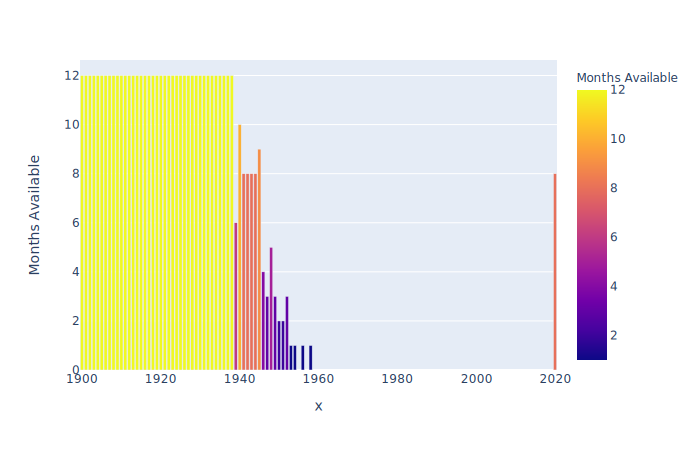

In [9]:
df = (pd.DataFrame(no_data, columns=['Year', 'Month']).groupby('Year').count())
fig = px.bar(df, y='Month', x=df.index,
             color='Month',
             labels={'Month': 'Months Available'}, height=400, width=800)
#go.FigureWidget(data=fig)
fig.show(renderer='svg')

> ## Let us create a dataframe with Years and Months as MultiIndex, this is very convenient for analysis based on time

In [ ]:
drug_df = pd.concat({key: pd.concat({mnts: dat for mnts, dat in vals.items()},
                                    names=['Months'])
                     for key, vals in drug_data.items()}, names=['Year'])

> ## Lets, look at how drug approval has evolved over the last 120 years,
- We plot, the total number of drugs approved in every year (left) and in every month (right)
- There is big surge in drug approval rate in the 80s, follwed by a big drop in 2003 and a constant raise afterwords and perhaps some slowing down in the recent years
- Month-wise data reveals that the data is mostly constant over different months. However, one can argue that there are peaksi n April and August

In [ ]:
%matplotlib widget
fig = make_subplots(rows=1, cols=2)
df = drug_df.groupby('Year').count()['Submission Status']
fig.add_trace(go.Bar(y=df.iloc[-100:],
                     x=df.index, name='Yearly', width=1),
              row=1, col=1)

df = drug_df.groupby('Months').count()['Submission Status']
fig.add_trace(go.Bar(y=df[MONTHS],
                     x=MONTHS, name='Monthly', width=1),
              row=1, col=2)
fig.update_layout(width=1000)
go.FigureWidget(data=fig)

># Let us try to focus on dominant players in the field
+ We take a look at the distributions of number of drugs each company has under its sleeve
+ Similarly, we take a look at how ingredients are distributed among different drugs

+ As expected, a lot of companies manufacture very few drugs (similar for ingredients)
+ However, there are a small number of companies that appear to the very right of the distribution, these are the BIG PLAYERS

In [ ]:
drug_list = drug_df['Active Ingredients'].astype(str).values
#ingredients_list = list(chain(*[drug.split(';') for drug in drug_list]))
ingredients_list=list([j.strip() for j in list(chain(*[i.split(';') for i in drug_list]))])

company_list = drug_df['Company'].astype(str).values

company_counts = Counter(company_list)
drug_counts = Counter(ingredients_list)

In [ ]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Histogram(x=list(company_counts.values()), name='Companies'),
              row=1, col=1)
fig.add_trace(go.Histogram(x=list(drug_counts.values()), name='Drugs', ),
              row=1, col=2)
fig.update_yaxes(type="log")
go.FigureWidget(data=fig)

># Top 20 Ingredients and Companies

In [ ]:
top_companies = dict((company_counts.most_common(20)))
top_drugs = dict((drug_counts.most_common(20)))

In [ ]:
pd.DataFrame(list(zip(top_drugs, top_companies)), columns=['Ingredients', 'Company Name'])

> ## Let us look at their market share

In [ ]:
df1 = pd.DataFrame(list(zip(company_counts.keys(), company_counts.values())), columns=['Company', '# of Drugs'])
df1.loc[~df1['Company'].isin(top_companies.keys()), 'Company'] = 'Others'
fig = px.pie(df1, values='# of Drugs', names='Company', title='Market share of Top Companies')
go.FigureWidget(data=fig)

> ## And share of the top ingredients in all the approved drugs

In [ ]:
df2 = pd.DataFrame(list(zip(drug_counts.keys(), drug_counts.values())), columns=['Compound', '# of Companies'])
df2.loc[~df2['Compound'].isin(top_drugs.keys()), 'Compound'] = 'Others'
fig=px.pie(df2, values='# of Companies', names='Compound', title='Company wide share of Top Ingredients')
go.FigureWidget(data=fig)

> ## Let us now see, how things have changed for different companies
1. The interactive plot below shows the number of drugs approved for a given company over time
2. One can choose two different companies for a comparison

In [ ]:
#widgets with variation over time
company1 = widgets.Dropdown(options=list(top_companies.keys()),
    value='MERCK', description='Company #0:',)
company2 = widgets.Dropdown(options=list(top_companies.keys()),
    value='NOVARTIS', description='Company #1:',)


# Assign an empty figure widget with two traces
trace1 = go.Scatter(y=drug_df[drug_df['Company'] == 'MERCK'].groupby('Year')['Submission']
                    .count(), x=drug_df[drug_df['Company'] == 'MERCK'].groupby('Year')['Submission']
                    .count().index, opacity=0.75,mode='lines+markers')
                    #marker_color='rgba(255.,150.,0.,0.8)', line_color='rgba(255., 150,0., 0.8)')

trace2 = go.Scatter(y=drug_df[drug_df['Company'] == 'NOVARTIS'].groupby('Year')['Submission']
                    .count(), x=drug_df[drug_df['Company'] == 'NOVARTIS'].groupby('Year')['Submission']
                    .count().index, opacity=0.75,mode='lines+markers')
                    #marker_color='rgba(150.,150.,255.,255)', line_color='rgba(255., 150,255., 255)')

g = go.FigureWidget(data=[trace1, trace2], layout=go.Layout(
                        title=dict(text='Evolution over the last century'),))
g.update_layout(xaxis_title='Year', yaxis_title='Number of Drugs Approved')

def response(change):
    filtered1 = drug_df[drug_df['Company']==company1.value].groupby('Year')['Submission'].count()
    filtered2 = drug_df[drug_df['Company']==company2.value].groupby('Year')['Submission'].count()
    with g.batch_update():
        g.data[0].y = filtered1
        g.data[0].x = filtered1.index

        g.data[1].y = filtered2
        g.data[1].x = filtered2.index

company1.observe(response, names="value")
company2.observe(response)
#container2 = widgets.HBox([trace1, trace2])
widgets.VBox([company1, company2, g])

> ## Let us now see, how things have changed for different compounds
1. The interactive plot below shows the number of drugs approved with a given ingredient
2. One can choose two different compounds/ingredients for a comparison

In [ ]:
#widgets with variation over time
drug1 = widgets.Dropdown(options=list(top_drugs.keys()),
    value='SODIUM CHLORIDE', description='Compd. #0:',)
drug2 = widgets.Dropdown(options=list(top_drugs.keys()),
    value='DEXTROSE', description='Compd. #1:',)


# Assign an empty figure widget with two traces
trace1 = go.Scatter(y=drug_df[drug_df['Active Ingredients'].str.contains('SODIUM CHLORIDE').fillna(False)].groupby('Year')['Approval Date'].count(), 
                    x=drug_df[drug_df['Active Ingredients'].str.contains('SODIUM CHLORIDE').fillna(False)].groupby('Year')['Approval Date'].count().index,
                    opacity=0.75,mode='lines+markers')
                    #marker_color='rgba(255.,150.,0.,0.8)', line_color='rgba(255., 150,0., 0.8)')

trace2 = go.Scatter(y=drug_df[drug_df['Active Ingredients'].str.contains('DEXTROSE').fillna(False)].groupby('Year')['Approval Date'].count(), 
                    x=drug_df[drug_df['Active Ingredients'].str.contains('DEXTROSE').fillna(False)].groupby('Year')['Approval Date'].count().index, 
                    opacity=0.75,mode='lines+markers')
                    #marker_color='rgba(150.,150.,255.,255)', line_color='rgba(255., 150,255., 255)')

g1 = go.FigureWidget(data=[trace1, trace2], layout=go.Layout(
                        title=dict(text='Evolution over the last century'),))
g1.update_layout(xaxis_title='Year', yaxis_title='Found in # of Drugs')

def response(change):
    filtered1 = drug_df[drug_df['Drug Name'].str.contains(drug1.value).fillna(False)].groupby('Year')['Approval Date'].count()
    filtered2 = drug_df[drug_df['Drug Name'].str.contains(drug2.value).fillna(False)].groupby('Year')['Approval Date'].count()
    with g.batch_update():
        g1.data[0].y = filtered1
        g1.data[0].x = filtered1.index

        g1.data[1].y = filtered2
        g1.data[1].x = filtered2.index

drug1.observe(response, names="value")
drug2.observe(response)
#container2 = widgets.HBox([trace1, trace2])
widgets.VBox([drug1, drug2, g1])

># Let us look at bit more advanced stuff

> ## Advanced
+ I want to look at how the ingredient evolutions are correlated with each other  
and   
+ How can be cluster them based on this simple dataset?

In [ ]:
# Correlation matrix of different companies and drugs
drug_coeff=[]
for drug in top_drugs:
    drug_coeff.append(drug_df[drug_df['Active Ingredients'].str.contains(drug).fillna(False)]
                      .groupby('Year')['Approval Date'].
                      count().reindex(drug_df.index.levels[0]).replace(np.nan, 0.).values)

In [ ]:
# we use the cluster map in seaborn to automatically do the clustering for us 
# we just have to input the correlation matrix
clus = sns.clustermap(np.corrcoef(drug_coeff),figsize=(6,6) )
lb=plt.setp(clus.ax_heatmap.get_yticklabels(), rotation=0)  
lb=plt.setp(clus.ax_heatmap.get_xticklabels(), rotation=90)
print(list(zip(np.arange(len(top_drugs.keys())), top_drugs.keys())))

>## Clustering the drug companies
1. To cluster among the drug companies, we look at the ingredients they have in common
2. Drugs manufacturing the same drugs are close to each other in the ingredient space and vice-versa
3. To define the 'distance', we define company vectors, just like word frequency vectors
4. Then, we have each company represented by a vector in the space of ingredients
5. We still, can't visually represent them, so we project them on to 2D plane using the popular t-SNE algorithm

In [ ]:
vectorizer=CountVectorizer()

top_companies = dict((company_counts.most_common(200)))
company_df=drug_df[drug_df['Company'].isin(top_companies.keys())]

word_vectors = vectorizer.fit_transform((company_df[['Company','Active Ingredients']].astype(str).groupby('Company').agg(' '.join))['Active Ingredients'].to_list())

tsne=TSNE(perplexity=50)
embedded1 = tsne.fit_transform(word_vectors)
tsne=TSNE(perplexity=500)
embedded2 = tsne.fit_transform(word_vectors)

In [ ]:
#%matplotlib inline
#plt.plot(embedded[:, 0], embedded[:, 1],'go', alpha = 0.8)
#plt.show()
fig = make_subplots(rows=1, cols=2,x_title='TSNE_1',y_title='TSNE_2')
fig.add_trace(go.Scatter(x=embedded1[:,0],y=embedded1[:,1], name='Low Perplexity', mode='markers', 
                         text=list(top_companies.keys())),
              row=1, col=1)
fig.add_trace(go.Scatter(x=embedded2[:,0],y=embedded2[:,1], name='High Perplexity', mode='markers',
              text=list(top_companies.keys())),
              row=1, col=2)

go.FigureWidget(data=fig)

___
* In the above plots, we can see the topology of the companies in the ingredient space
* We do this at two different perplexities for a better understanding of the topology
    + These two figures suggest that, the topology is perhaps a ring in higher dimensions, with some variance in the direction perpendicular to the plane of the ring
* On hover, we can see which comanies are close to each other and which are not!
* Finally, it is interesting to see that, all the companies lie on ring forming a closed loop   
(with some outliers, Dr. Reddy's, Novartis and Heritage Pharma)
----

In [ ]:
# Conclusions

In [ ]:
# Graphs?
# New info? diseases? side-effects?
# prices of drugs?

# relationships?
# companies with common drugs or the reverse --- can make clusters 
# companies that make a lot of drugs

# comparitive study with a different drug database -- from different country